In [5]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import neptune
from minatar import Environment

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from itertools import islice

#env = gym.make("CartPole-v1")

# device = torch.device(
#     "cuda" if torch.cuda.is_available() else
#     "mps" if torch.backends.mps.is_available() else
#     "cpu"
# )
# If CUDA is available (i.e., a CUDA-compatible GPU is present) it will be used for torch computations
# If CUDA is not available, the code checks if the MPS (Metal Performance Shaders) backend is available. This is used on macOS devices with Apple Silicon (M1, M2 chips)
# If neither CUDA nor MPS is available, the code defaults to using the CPU

In [4]:
!pip install minatar

In [2]:
!pip install neptune-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.7/502.7 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.4 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67675 sha256=b16a6d584dee1f9b9d6a0dbdae1f1982b1a291a336a85e6f28b8970cf2df60c0
  Stored in directory: /root/.cache/pip/wheels/cf/d7/1c/1d707a21e0a0323bdbfbb2f6de125ae6bb70d62aa2838df321
Successfully built bravado-core


In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
#a named tuple is similar to a regular tuple but it allows you to access the elements by name instead of by index (e.g. transition.state instead of transition[0])
#used to store each experience in the replay memory in a structured way.

class ReplayMemory(object): #Define a class to store and sample transitions.
    #The class is part of a replay buffer that holds experience tuples for use in training an RL agent.

    def __init__(self, capacity):#initialize the replay memory
        self.memory = deque([], maxlen=capacity)#creates a double-ended-queue with a maximum length of capacity.
        #Deque allows efficient appending at both ends. When the memory exceeds the capacity, the oldest transition is discarded


    def push(self, *args):#save a new transition to memory
        """Save a transition"""
        self.memory.append(Transition(*args))#*args allows the function to accept any number of arguments
        #append new Transition to the deque. The transition is constructed by unpacking the arguments into the Transition named tuple

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)#select batch_size random transitions from self.memory without replacement

    def __len__(self):
        return len(self.memory) #returns current size of the memory (the number of transitions currently stored in replay memory)

In [7]:
class DQN(nn.Module):#still need to understnad this
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        # Unpack input shape (height, width, channels)
        h, w, c = input_shape  # h: height (10), w: width (10), c: number of channels

        #Convolutional layers to process the input images
        #conv1: takes c input channels (frames), applies 16 filters of size 3x3, with stride 1
        #conv2: takes 16 input channels from conv1 applies 32 filters of size 3x3
        #the goal of these layers is to extract useful spatial features fromthe images
        self.conv1 = nn.Conv2d(c, 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)

        # Compute size of output after convolutions
        def conv2d_size_out(size, kernel_size=3, stride=1):
            return (size - (kernel_size - 1) - 1) // stride + 1

        convw = conv2d_size_out(conv2d_size_out(w))
        convh = conv2d_size_out(conv2d_size_out(h))
        linear_input_size = convw * convh * 32

        self.fc1 = nn.Linear(linear_input_size, 128)
        self.fc2 = nn.Linear(128, n_actions)

    def forward(self, x):
        # Permute the input from (batch_size, height, width, channels) to (batch_size, channels, height, width)
        #need to do this to match shape expected for torch's Conv2d
        x = x.permute(0, 3, 1, 2)  # Reorder dimensions to match PyTorch's Conv2d format: (batch_size, c, h, w)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1)  # Flatten before fully connected layers
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [11]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
class DQNLearner:
    def __init__(self,
               env,
               device,
               run,
               BATCH_SIZE = 128,
               GAMMA = 0.99,
               EPS_START = 0.9,
               EPS_END = 0.05,
               EPS_DECAY = 1000,
               TAU = 0.005,
               LR = 1e-4,
               num_episodes=1000):
        self.batch_size= BATCH_SIZE
        self.gamma= GAMMA
        self.eps_start=EPS_START
        self.eps_end = EPS_END
        self.eps_decay=EPS_DECAY
        self.tau = TAU
        self.lr=LR
        self.num_episodes=num_episodes

        self.device=device

        self.env=env

        self.run=run

        # Get number of actions from gym action space
        ###THIS CHANGED FOR MINATAR
        n_actions = self.env.num_actions()
        # Reset and get the number of state observations
        ###THIS CHANGED FOR MINATAR
        self.env.reset()
        state=self.env.state()


        ###THIS CHANGED FOR MINATAR
        # Assuming state shape is (10, 10, c), where c is the number of channels
        self.policy_net = DQN(state.shape, n_actions).to(device)
        self.target_net = DQN(state.shape, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        #policy_net.state_dict() retrieves the current weights (parameters) of the policy network.
        #target_net.load_state_dict(...) copies these weights to the target network
        #ensures that the target network's parameters match those of the policy network at this point in time

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True)
        self.memory = ReplayMemory(10000)


        self.steps_done = 0


    def select_action(self, state):
        sample = random.random()#returns a random float between 0.0 and 1.0
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
        #decay epsilon each time the agent chooses an action
        #exponential decay
        self.steps_done += 1 #track how many steps in total (over all episodes) agent has taken so far
        #epislon-greedy
        if sample > eps_threshold:
            with torch.no_grad():#turn off gradient calculation since don't need to update weights yet
                return self.policy_net(state).max(1).indices.view(1, 1)
            #self.policy_net(state) gived the Q values for each possible action in the current state
            #.max(1) finds the maximum Q-value accross the actions. It will returns the maximum values and the indices of the actions with these values.
            #.indices refers to the second output of .max(1) which is the index of the action with the highest Q_value
            #.view(1,1) reshapes the indices tensor into a 1X1 tensor to match the required output format for the action, as expected for the rest of the code
        else:
            return torch.tensor([[random.randrange(self.env.num_actions())]], device=self.device, dtype=torch.long)
        #return a random action from the environment's action space and convert to pytorch tensor with correct shape
        #

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return #exit if memory too small
        transitions = self.memory.sample(self.batch_size) #randomly samples a batch of self.BATCH_SIZE transitions from memory
        #result is a list of self.BATCH_SIZE transitions each containing a tuple of (state, action, next_state, reward)
        batch = Transition(*zip(*transitions)) #unzip the list of transitions into four separate lists, one for each element of the tuple

        #Prepare the data from the replay memory to be fed into the DQN for training
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=self.device, dtype=torch.bool)
        #batch.next_state is the list of next states from the sampled batch of transitions. Some of these may be None if the episode has ended.
        #use a lambda function to check element is not None
        #The map function applies the lambda function to each element in batch.next_state, resulting in a sequence of True or False values
        #tuple() converts the result of map into a tuple
        #torch.tensor converts the tuple into a tenosr of boolean values
        #non_final_mask is a boolean tensor that marks whether the next state for each transition is non-terminal (i.e. not NOne)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        #iterate through batch.next_state and select only the states that are not None (filters out terminal states)
        #concatenate the list into a single tensor
        #contains all non-terminal states

        state_batch = torch.cat(batch.state)#concatenate all states in batch.state into a single tensor
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        #compute the Q values for all actions for each state in the batch
        #output (batch_size, num_actions) with each row corresponding to a state and each column corresponds to a Q-value for a specific action
        #action_batch has dimension (batch_size, 1)
        #.gather for each state in the batch, we gather the Q value corresponding to the action the agent took
        #resulting tensor has shape (batch_size,1) and will contain the Q-values for the actions that were taken

        #Compute target Q-values
        next_state_values = torch.zeros(self.batch_size, device=self.device)#intialize tensor that will hold the maximum Q-values for the next state
        with torch.no_grad():#we do not need gradients for the target network (its only needed for evaluating the value of the next state)
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values #non_final_next_states contains only valid next states
            #.max(1) returns the maximum Q-value for each state in the batch accross dif possible actions
            #.values just to get values not indices
            #LHS of the assignment  updates the next_state_values tensor with the maximum Q-values for the valid next states
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch
        #calculate the target Q-values used in the update

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        #unsqueeze to get tneosr dimensions to match. Adds extra dimension to target to get same dimension (batch_size,1)

        # Optimize the model
        self.optimizer.zero_grad()#clears gradients of parameters in the model (reset to avoid adding gradients from previous steps)
        loss.backward()#computes gradients of the loss with respect to the model's parameters
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)#clips maximum gradient to 100 to prevent exploding gradients
        self.optimizer.step()#updates the models parameters using the gradients calculated in the previous step

    def train(self):
        episode_returns = []

        for i_episode in range(self.num_episodes):
            # Initialize the environment and get its state
            self.env.reset()
            # state() returns a NumPy array of shape (10, 10, c)
            state=self.env.state()
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            #Convert state to a PyTorch tensor (still shape: (10, 10, c))
            # unsqueeze(0) adds a batch dimension, making it (1, 10, 10, c)

            # When passed to self.policy_net(state), the forward function in DQN will:
            # - Automatically permute it from (1, 10, 10, c) to (1, c, 10, 10)
            # - This ensures compatibility with PyTorch's Conv2d layers
            for t in count(): #count() generates an infinite sequence of numbers starting from o which makes the loop continue indefinitely until a break condition is met
                #runs until the episode ends
                action = self.select_action(state)
                reward, terminated= self.env.act(action.item())
                observation = self.env.state()
                #select_action returns a tensor of shape (1,1) with dimension for the batch size. But act(a) function expects a single integer action, so need .item()
                reward = torch.tensor([reward], device=self.device)
                done = terminated
                #there was no truncated

                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32, device=self.device).unsqueeze(0)

                # Store the transition in memory
                self.memory.push(state, action, next_state, reward)

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                self.optimize_model()

                # Soft update of the target network's weights
                # θ′ ← τ θ + (1 −τ )θ′
                # θ′ is target network's weight
                # θ is policy network's weight
                #effectively a weighted sum
                #target network's weight gradually adjusted toward the policy network's weight

                #rather than copying the policy network's weights directly, the soft update blends the weights of the target network and the policy network.
                #This helps to avoid abrupt changes that can destabilize learning.

                #get current weights of both networks
                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                #update each weight in target network using the soft udpdate rule
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1-self.tau)
                self.target_net.load_state_dict(target_net_state_dict)

                if done:
                    # print(f"Testing deque slicing: {list(self.memory.memory[-3:])}")
                    # print(f"Length of memory: {len(self.memory.memory)}")
                    # print(f"Memory contents: {list(self.memory.memory)[:5]}")  # Print the first 5 elements to inspect
                    # print(f"Type of t: {type(t)}, Value of t: {t}")
                    # print(type(self.memory.memory))
                    # print(type(t), t)
                    episode_return = sum(transition.reward.item() if isinstance(transition.reward, torch.Tensor) else transition.reward for transition in islice(self.memory.memory, len(self.memory.memory) - (t+1), len(self.memory.memory)))
                    #self.memory.memory is the list storing all transitions experienced by the agent. Each transition is a tuple containing the state, action, next state and reward
                    #itertools.islice(iterable, start, stop) iterable: the collection you want to iterate over; start:starting index (inclusive); stop: stopping index (exclusive)
                    #get only the transitions from the current episode. t is the current time step within the episode, so -(t+1) gets the last t+1 transitions.
                    #The epuside consists of t+1 transitions because the time steps start at 0
                    #the conditional expression checks if the reward from a Transition object is a torch.Tensor, and if so, it converts it to a regular Python number (e.g., float). If it's not a torch.Tensor, it simply uses the reward as it is.
                    episode_returns.append(episode_return)
                    self.run["episode_returns"].log(episode_return)
                    #print(t+1)

                    #plot_durations()
                    break

        return episode_returns

In [ ]:
env = Environment(env_name="breakout")
#print(dir(env))
print(env.num_actions())

6


In [ ]:
print(dir(env))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'act', 'close_display', 'closed', 'display_state', 'env', 'env_name', 'game_name', 'last_action', 'minimal_action_set', 'n_channels', 'num_actions', 'random', 'reset', 'seed', 'state', 'state_shape', 'sticky_action_prob', 'visualized']


In [ ]:
env.reset()
state=env.state()
print(state.shape[3])
#n_observations = len(state)
#print(n_observations)

IndexError: tuple index out of range

In [15]:
def main_Minatar(learning_rate,batch_size, eps_decay):
    my_api="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjZDg3ZjNlYi04MWI3LTQ1ODctOGIxNS1iNTY3ZjgzMGYzMzYifQ=="
    run = neptune.init_run(
    project="EnergyGridRL/DQN-Minatari",
    api_token=my_api
)  # your credentials
    # Create the environment
    params = {"BATCH_SIZE":batch_size,#32 smaller batch size can work better for MinAtari
               "GAMMA":0.99,
               "EPS_START":1.0,#start with full exploration
               "EPS_END":0.05,
               "EPS_DECAY": eps_decay,#5000 decay epsilon over a longer period for stability
               "TAU": 0.005,
               "LR":learning_rate,#1e-4
               "num_episodes":10000,
}
    run["parameters"] = params# Use the grid size in the environment
    env = Environment(env_name="breakout")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    # Create the Q-LEARNING agent
    agent = DQNLearner(
               env=env,
               device=device,
               run=run,
               BATCH_SIZE = params["BATCH_SIZE"],
               GAMMA = params["GAMMA"],
               EPS_START = params["EPS_START"],
               EPS_END = params["EPS_END"],
               EPS_DECAY = params["EPS_DECAY"],
               TAU = params["TAU"],
               LR = params["LR"],
               num_episodes=params["num_episodes"])

    # Train the agent
    episode_returns = np.array(agent.train())

    # Stop the Neptune run
    run.stop()

    plt.plot(episode_returns)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Performance")
    plt.show()

In [ ]:
main_Minatar(1e-4,32,5000)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-Minatari/e/DQNMIN-8
Using device: cuda


In [ ]:
def mainCartPole(learning_rate,batch_size, eps_decay):
    my_api="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjZDg3ZjNlYi04MWI3LTQ1ODctOGIxNS1iNTY3ZjgzMGYzMzYifQ=="
    run = neptune.init_run(
    project="EnergyGridRL/DQN-CartPole",
    api_token=my_api
)  # your credentials
    # Create the environment
    params = {"BATCH_SIZE":batch_size,#128
               "GAMMA":0.99,
               "EPS_START":0.9,
               "EPS_END":0.05,
               "EPS_DECAY": eps_decay,#1000
               "TAU": 0.005,
               "LR":learning_rate,#1e-4
               "num_episodes":1000,
}
    run["parameters"] = params# Use the grid size in the environment
    env = gym.make('CartPole-v1')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    # Create the Q-LEARNING agent
    agent = DQNLearner(
               env=env,
               device=device,
               run=run,
               BATCH_SIZE = params["BATCH_SIZE"],
               GAMMA = params["GAMMA"],
               EPS_START = params["EPS_START"],
               EPS_END = params["EPS_END"],
               EPS_DECAY = params["EPS_DECAY"],
               TAU = params["TAU"],
               LR = params["LR"],
               num_episodes=params["num_episodes"])

    # Train the agent
    episode_returns = np.array(agent.train())

    # Stop the Neptune run
    run.stop()

    plt.plot(episode_returns)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Performance")
    plt.show()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-47
Using device: cpu
57
11
18
15
16
17
18
18
12
12
23
9
20
11
13
11
14
13
16
22
26
12
22
11
10
19
9
9
11
14
23
11
11
13
12
10
10
10
9
15
15
23
13
13
18
22
13
16
19
15
18
15
11
15
12
13
11
16
12
12
13
14
15
12
14
17
12
11
12
11
11
14
14
17
16
13
13
12
11
21
20
12
18
12
15
16
14
18
13
18
18
18
14
14
20
19
16
27
20
31
17
17
20
25
25
21
15
34
27
32
29
16
20
30
26
28
21
26
32
26
25
41
25
31
34
43
25
44
89
80
127
190
146
190
131
99
47
15
54
12
12
13
10
12
11
53
11
12
52
11
17
9
10
12
9
11
13
10
11
9
11
10
10
12
10
13
11
12
43
12
48
11
12
13
14
11
12
10
10
12
11
9
12
11
12
10
12
10
13
12
9
10
9
10
12
9
9
9
10
12
9
10
9
12
10
9
9
12
12
10
11
9
8
11
8
10
9
9
10
10
10
11
11
10
12
9
9
11
9
10
9
9
12
10
9
9
11
10
10
9
9
10
10
9
10
9
11
11
8
9
10
41
9
35
10
79
104
70
12
117
54
169
126
153
126
193
132
133
179
175
147
149
172
186
152
196
179
157
159
180
147
208
162
148
211
152
177
182
1

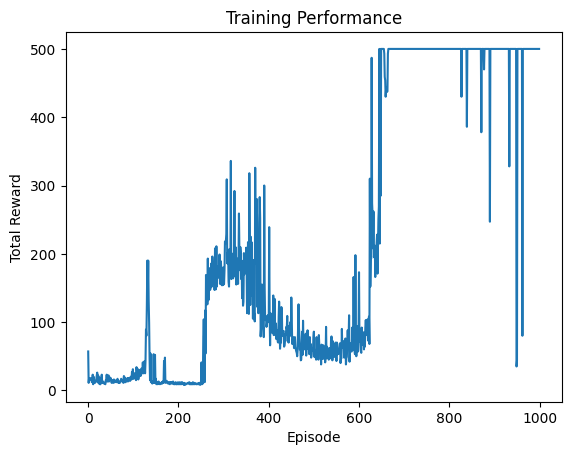

In [ ]:
mainCartPole(1e-4,128, 1000)

python(87413) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(87422) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(87423) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(87424) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(87425) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(87426) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-112
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-112/metadata


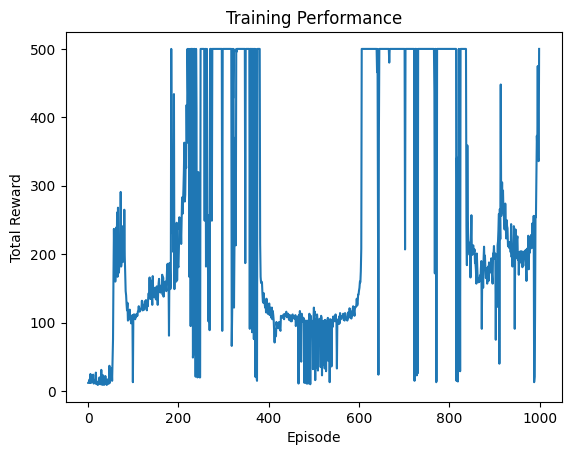

python(88401) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88402) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88403) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88404) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-113


python(88405) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88406) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-113/metadata


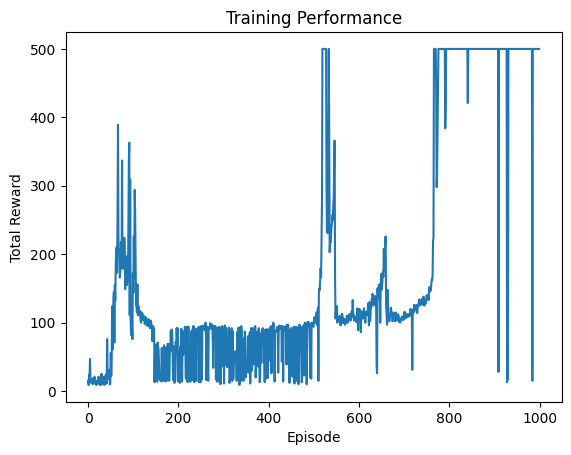

python(89128) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89129) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89130) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89131) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-114


python(89132) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89133) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-114/metadata


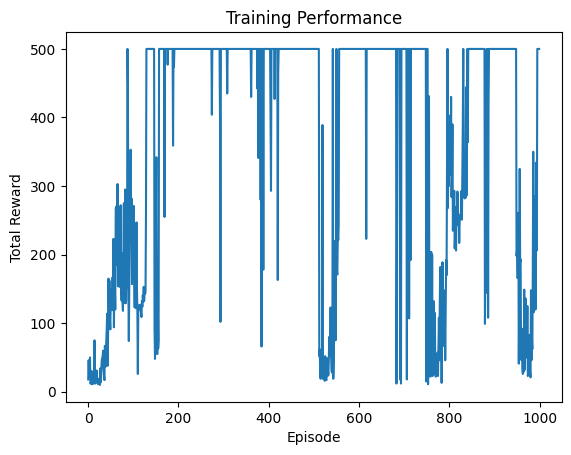

python(89952) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89953) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89954) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89955) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-115


python(89958) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89962) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-115/metadata


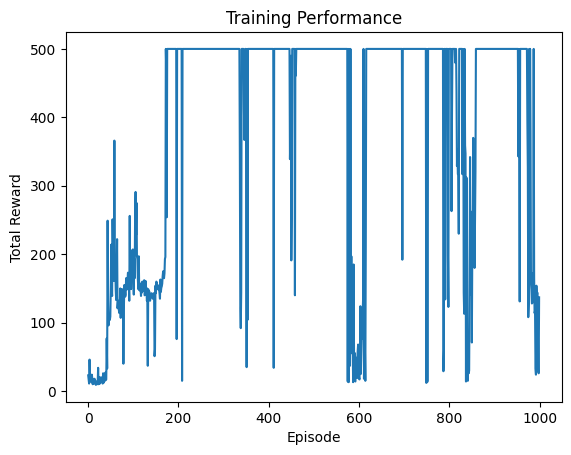

python(90861) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(90862) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(90863) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(90864) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-116


python(90865) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(90866) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-116/metadata


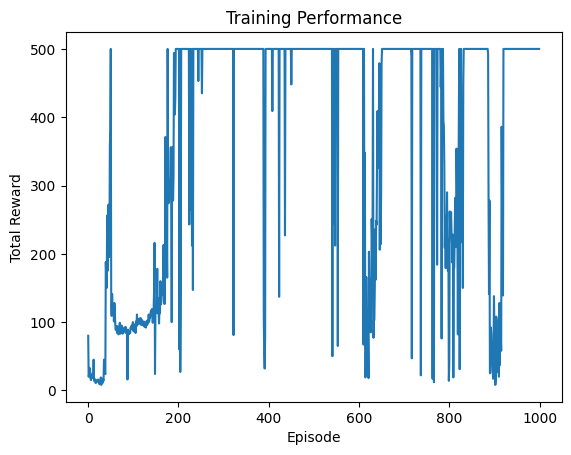

python(91735) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(91736) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(91737) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(91738) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-117


python(91739) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(91740) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 4 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-117/metadata


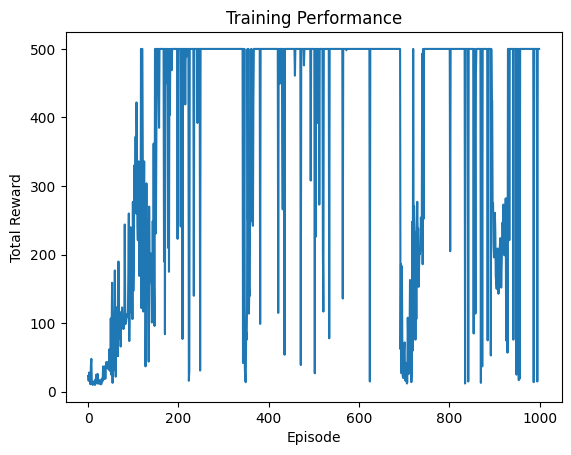

python(93405) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(93406) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(93407) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(93408) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-118


python(93409) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(93410) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-118/metadata


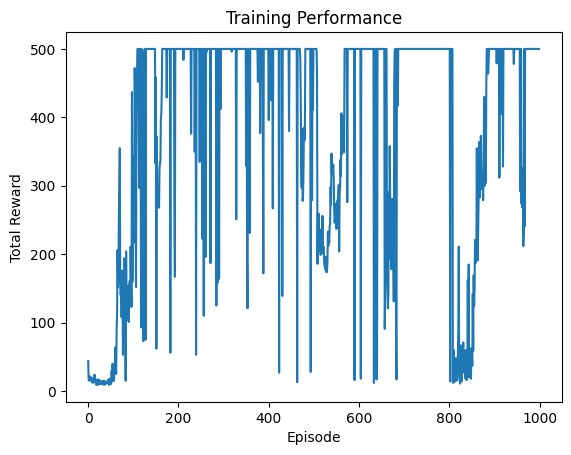

python(94576) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(94577) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(94578) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(94579) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-119


python(94580) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(94581) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-119/metadata


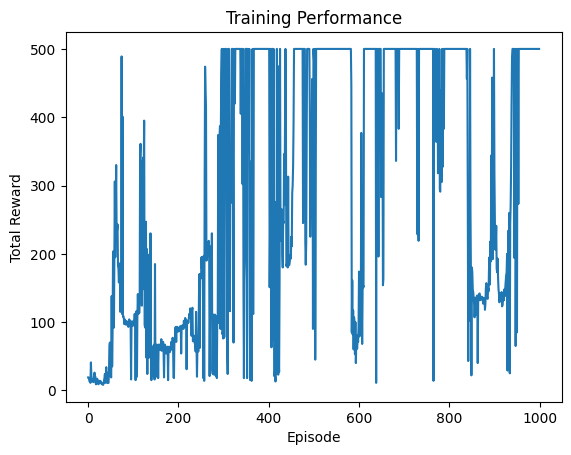

python(95566) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95567) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95568) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95569) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-120


python(95570) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(95571) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-120/metadata


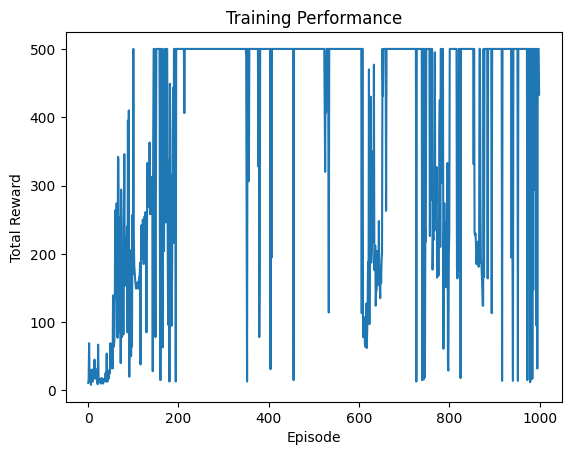

python(96811) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96812) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96813) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96814) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-121


python(96815) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96816) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-121/metadata


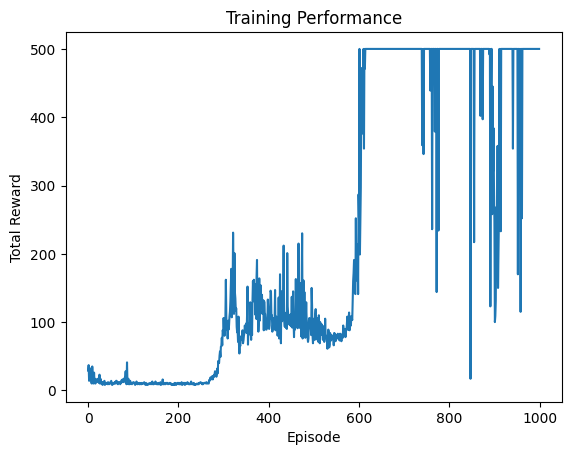

python(97260) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(97261) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(97262) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(97263) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-122


python(97264) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(97265) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [warning] Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: ConnectionError
[neptune] [warning] Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: ConnectionError
[neptune] [warning] Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: ConnectionError
[neptune] [info   ] Communication with Neptune restored!
[neptune] [info   ] Communication with Neptune restored!
[neptune] [info   ] Communication with Neptune restored!
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-122/metadata


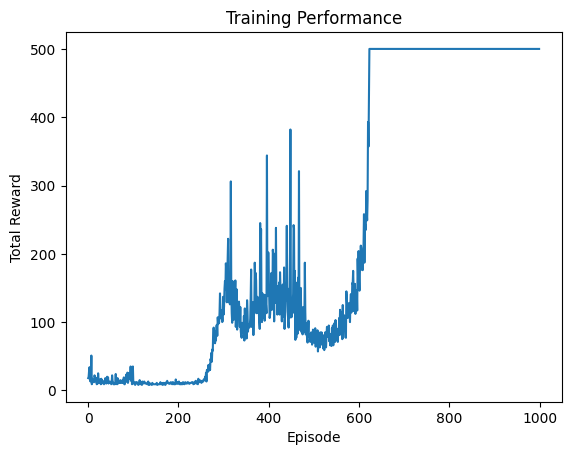

python(98250) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98251) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98252) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98253) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98256) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98258) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-123
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-123/metadata


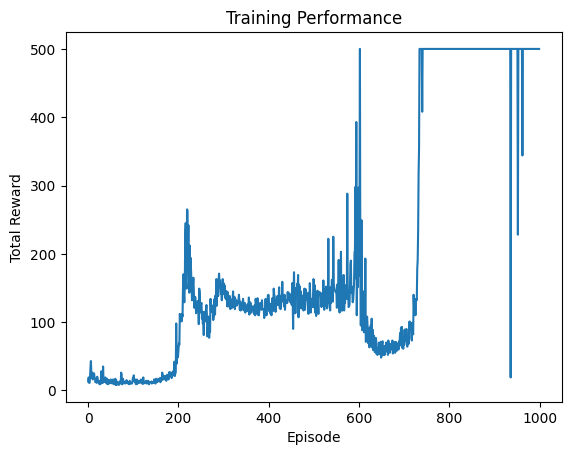

python(99094) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(99095) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(99096) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(99097) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-124


python(99099) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(99100) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-124/metadata


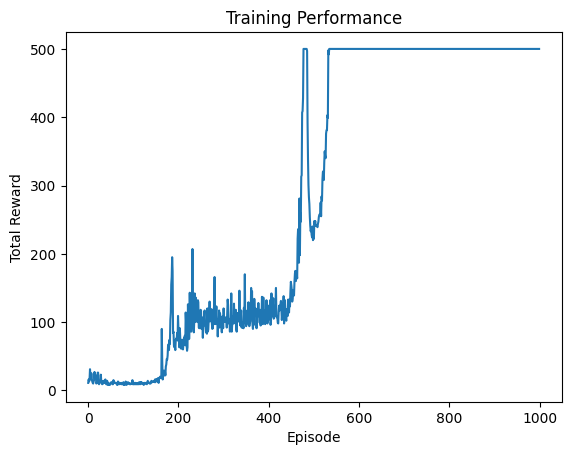

python(720) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(727) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(730) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(732) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-125


python(733) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(735) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-125/metadata


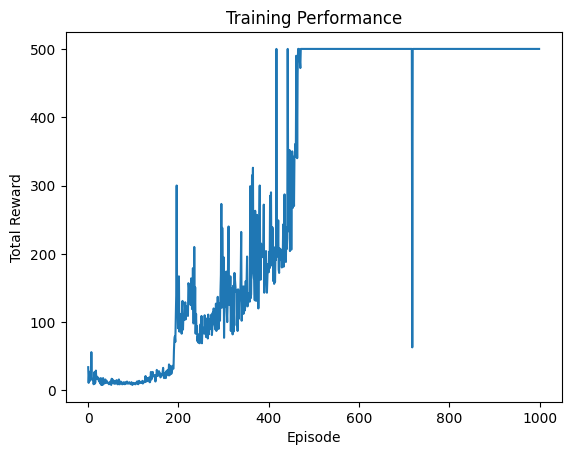

python(1920) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1921) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1922) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1923) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1924) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1925) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-126
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-126/metadata


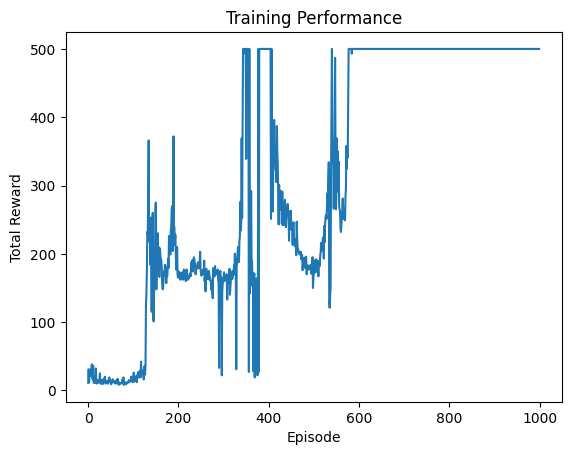

python(3962) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3963) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3964) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3965) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-127


python(3966) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3967) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-127/metadata


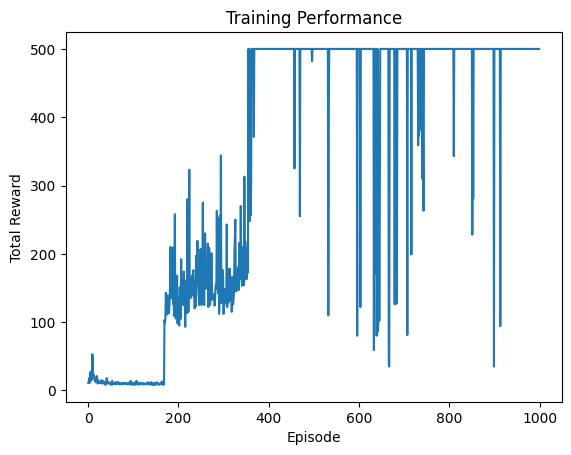

python(5512) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(5513) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(5514) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(5515) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-128


python(5517) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(5518) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-128/metadata


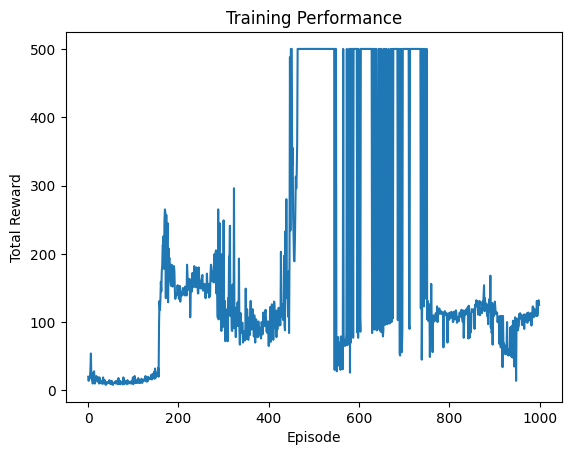

python(6494) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6495) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6496) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6497) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-129


python(6498) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6499) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-129/metadata


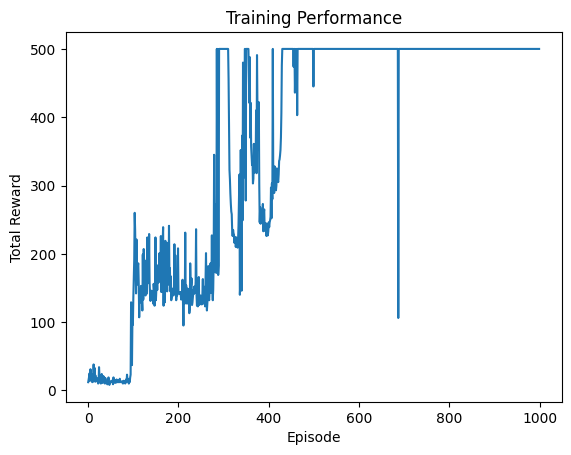

python(8194) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8197) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8198) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8199) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-130


python(8200) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8201) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 13 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 13 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-130/metadata


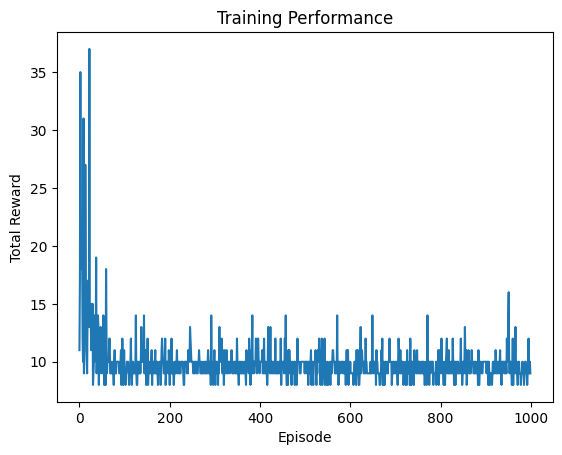

python(8258) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8259) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8260) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8262) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8263) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8264) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-131
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 97 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 97 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-131/metadata


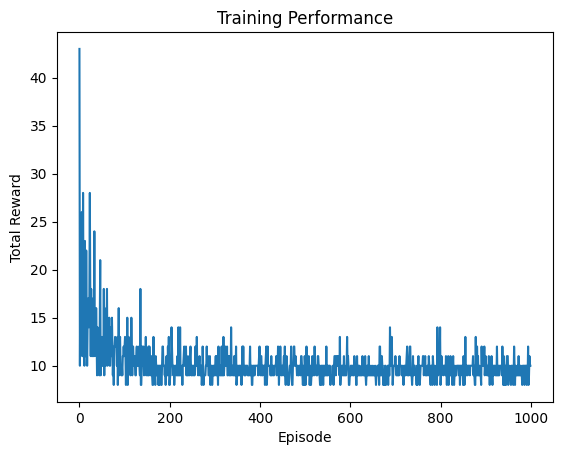

python(8306) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8307) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8308) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8309) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-132


python(8311) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8312) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 131 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 131 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-132/metadata


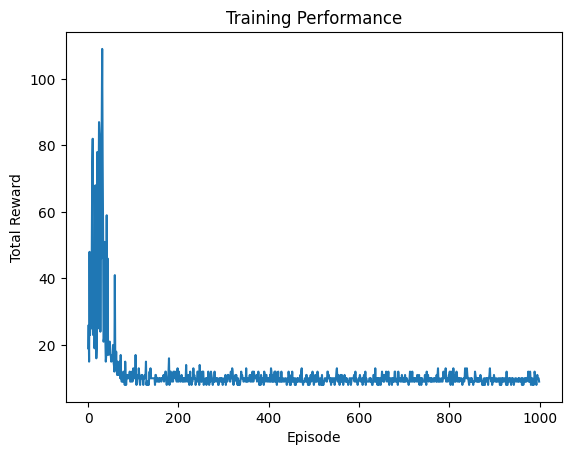

python(8372) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8374) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8375) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8376) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-133


python(8377) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8378) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 51 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 51 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-133/metadata


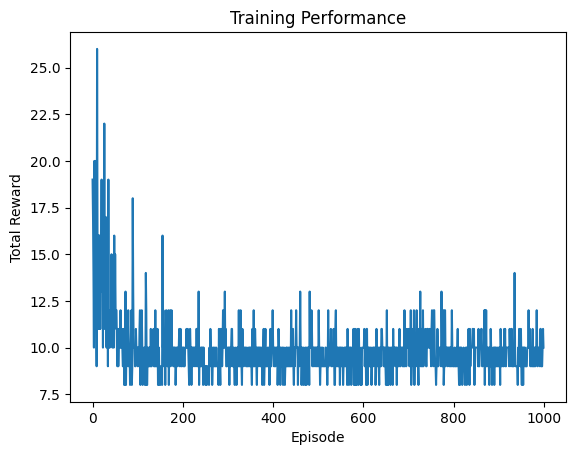

python(8425) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8427) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8429) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8430) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8432) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8433) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-134
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 29 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 29 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-134/metadata


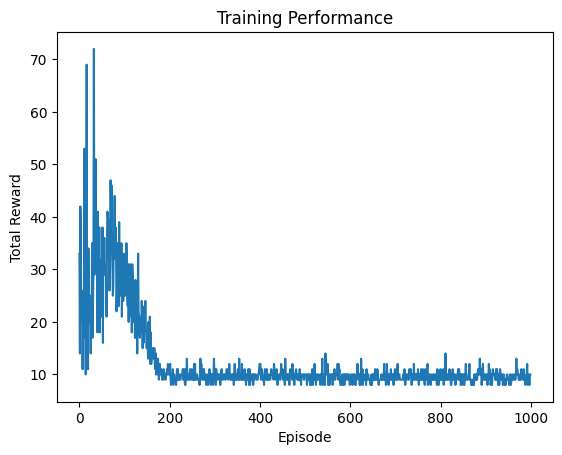

python(8563) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8564) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8566) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8567) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8570) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-135


python(8571) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 52 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 52 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-135/metadata


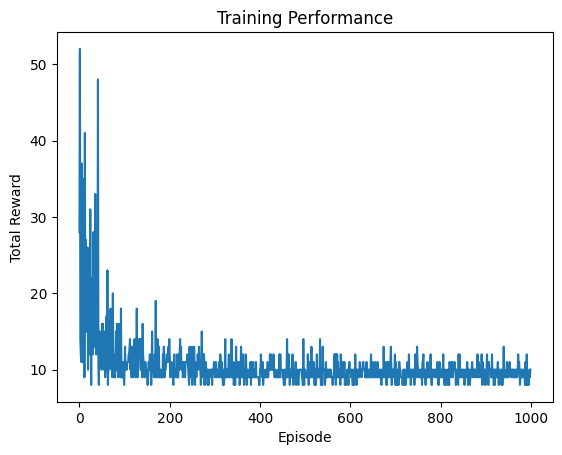

python(8671) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8672) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8673) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8674) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-136


python(8675) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8676) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 43 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 43 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-136/metadata


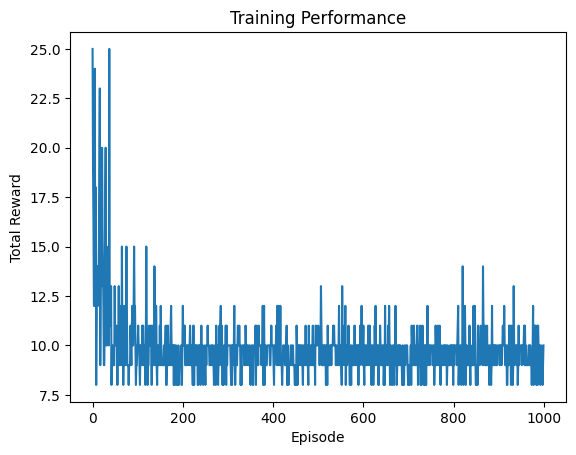

python(8889) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8890) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8891) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8892) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8896) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8898) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-137
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 55 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 55 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-137/metadata


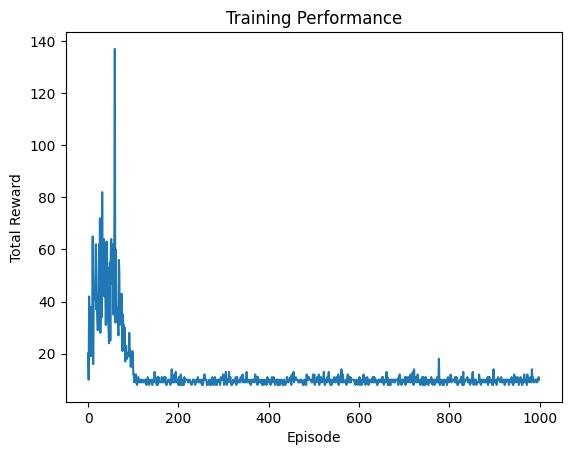

python(9047) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9048) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9049) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9054) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-138


python(9055) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9056) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 68 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 68 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/DQN-CartPole/e/DQNCAR-138/metadata


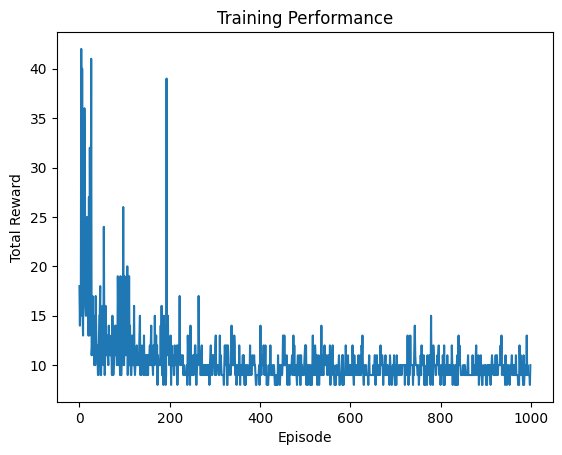

In [ ]:
learning_rates=[1e-3,1e-4,1e-5]
batch_sizes=[64,128,256]
eps_decays=[500,1000,1500]

for lr in learning_rates:
        for bs in batch_sizes:
            for ed in eps_decays:
                mainCartPole(lr,bs, ed)